In [1]:
PIPELINE_CONTEXT = {"_runtime_context_name": "PIPELINE_CONTEXT", "params": {"n_clusters": "auto", "n_clusters_min": 6, "n_clusters_max": 50, "n_clusters_criterion": "silhouette", "pca_components": "auto", "pca_variance": 0.9, "pca_max_components": 50, "random_state": 42}, "artifacts": {"dir": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200", "processed_data": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/processed.parquet", "model_file": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/kmeans_model.joblib", "scaler_file": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/scaler.joblib", "pca_file": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/pca.joblib", "cluster_summary": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/cluster_summary.json", "elbow_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/elbow_plot.png", "silhouette_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/silhouette_plot.png", "db_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/db_plot.png", "ch_plot": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/ch_plot.png", "selection": "/Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/selection.json"}, "cwd": "/Users/savvasneofytou/Desktop/basketball/pipeline", "data_dir": "/Users/savvasneofytou/Desktop/basketball/data/output_by_college_clean"}

**Pipeline Context**

In [2]:
try:
    ctx = PIPELINE_CONTEXT
except NameError:
    import os
    ctx = {
        "params": {},
        "artifacts": {
            "dir": "artifacts",
            "processed_data": "artifacts/processed.parquet",
            "model_file": "artifacts/kmeans_model.joblib",
            "scaler_file": "artifacts/scaler.joblib",
            "pca_file": "artifacts/pca.joblib",
            "cluster_summary": "artifacts/cluster_summary.json",
            "elbow_plot": "artifacts/elbow_plot.png",
            "silhouette_plot": "artifacts/silhouette_plot.png",
            "selection": "artifacts/selection.json",
        },
        "data_dir": "data",
    }

from pathlib import Path
import json

P = ctx.get("params", {})
PATHS = ctx.get("artifacts", {})
DATA_DIR = ctx.get("data_dir", "data")
Path(PATHS["dir"]).mkdir(parents=True, exist_ok=True)

def save_json(obj, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=float)

def load_json(path, default=None):
    p = Path(path)
    if p.exists():
        return json.loads(p.read_text())
    return {} if default is None else default


**Imports**

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**Data Importing**

In [4]:
# Load the dataset
data = pd.read_csv('player_features_cleaned.csv')

# Basic checks
print("Shape:", data.shape)
print("\nColumns:\n", data.columns.tolist())
print("\nData types & non‐null counts:")
print(data.info())

# Quick summary statistics
print("\nSummary statistics:")
print(data.describe().T)

# Check for missing values
missing = data.isnull().sum()
print("\nMissing values per column:")
if missing.sum() == 0:
    print("No missing values found.")
else:
    print(missing[missing > 0])


Shape: (2078, 81)

Columns:
 ['college', 'season', 'player_number_ind', 'player_ind', 'gp_ind', 'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind', 'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40', 'ast_per40', 'stl_per40', 'blk_per40', 'to_per40', 'eFG_pct', 'TS_pct', 'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO', '3pt_3pt_pct_ind', 'three_per40', 'threeA_per40', 'three_per100', 'threeA_rate', 'DRCR', 'STL_TO_ratio', 'def_stops_per100', 'DPMR', 'TUSG_pct', 'Gravity', 'PPT', 'Spacing', 'Assist_to_Usage', 'APC', 'PEF', 'OEFF', 'TOV_pct', 'SEM', 'PEI', 'BoxCreation', 'OLI', 'IPM', 'threeA_per100', '2pt_pct', 'FTr', 'PPP', 'possessions', 'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100', 'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game', 'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game', 'to_per_game', 'scoring_pts_share', 'ast_share', 'rebounds_tot_share', 'stl_share', 'blk_share', 'to_share', 'team

**Histograms, Density Plots and Box Plots**

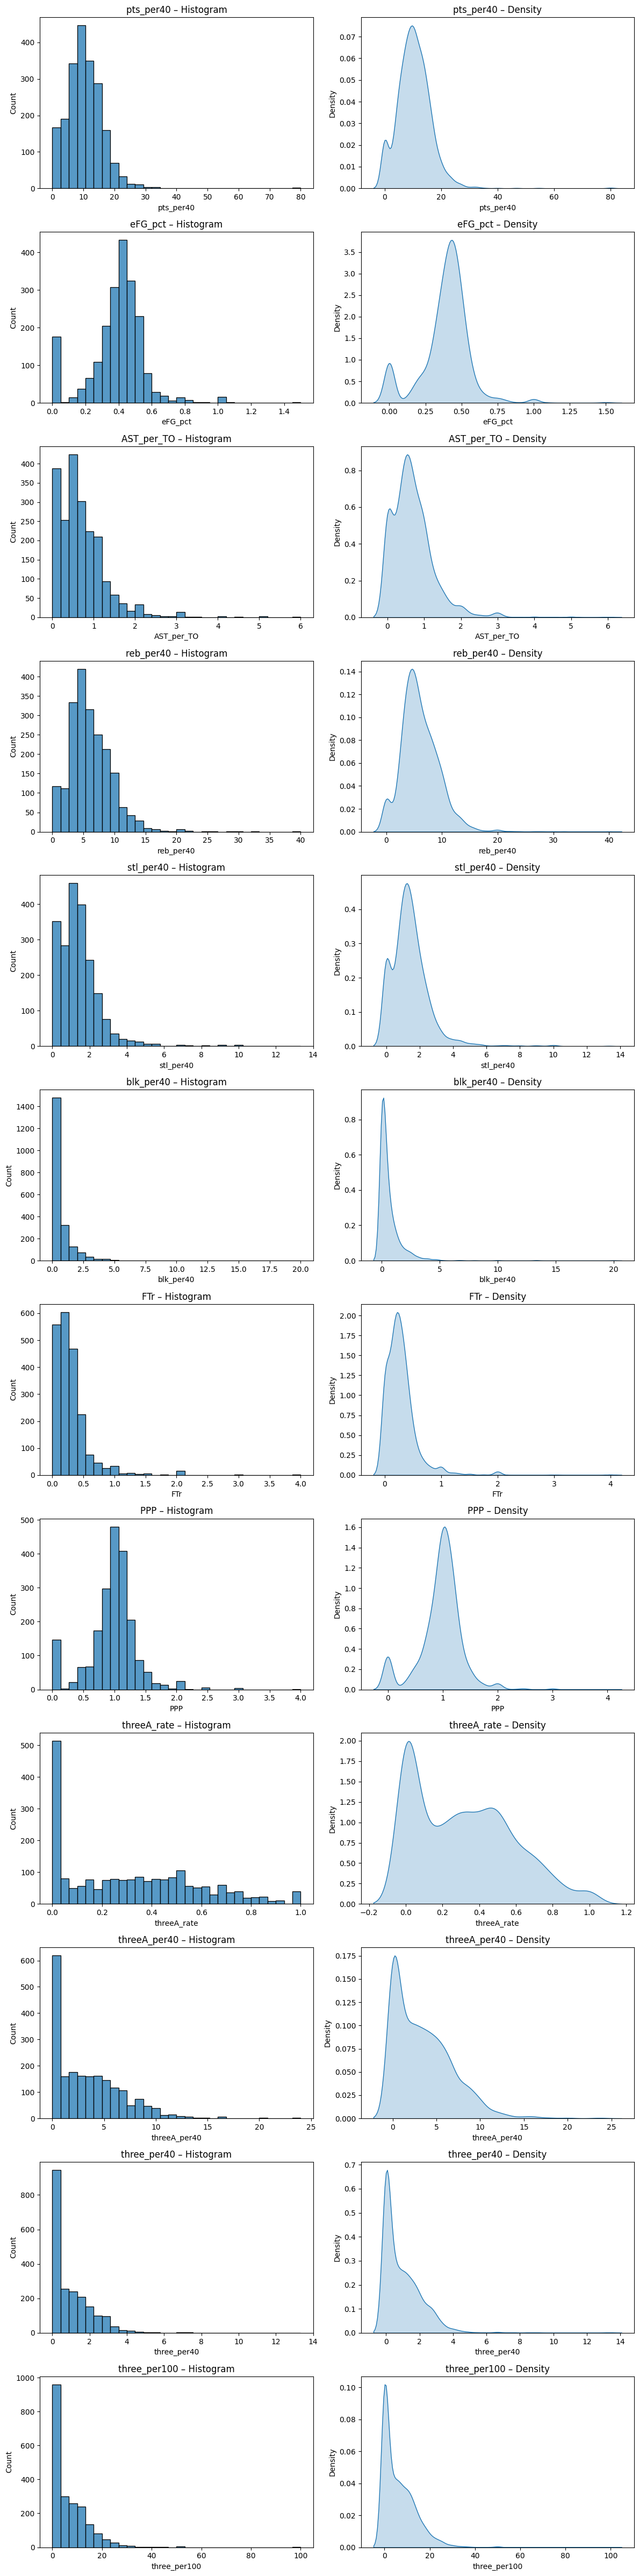

In [5]:
# Histograms & density plots for selected features
features = [
    'pts_per40','eFG_pct','AST_per_TO','reb_per40',
    'stl_per40','blk_per40','FTr','PPP', 'threeA_rate','threeA_per40',
    'three_per40','three_per100'
]

fig, axes = plt.subplots(len(features), 2, figsize=(12, 4*len(features)))

for ax_row, col in zip(axes, features):
    sns.histplot(data[col], bins=30, ax=ax_row[0], kde=False)
    ax_row[0].set_title(f"{col} – Histogram")
    
    sns.kdeplot(data[col], fill=True, ax=ax_row[1])
    ax_row[1].set_title(f"{col} – Density")

plt.tight_layout()


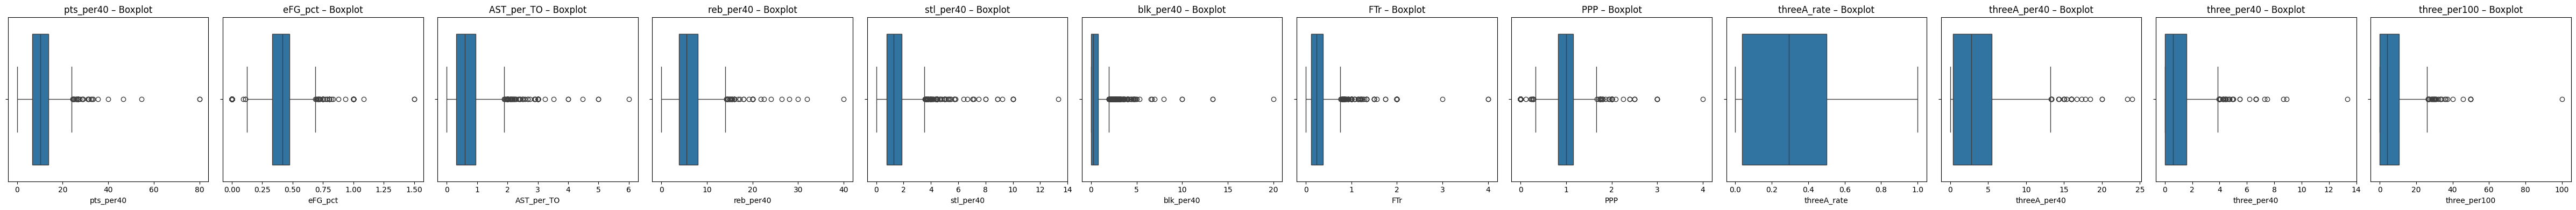

In [6]:
# Boxplots to spot outliers in the same features
fig, axes = plt.subplots(1, len(features), figsize=(4*len(features), 4), sharey=True)

for ax, col in zip(axes, features):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f"{col} – Boxplot")

plt.tight_layout()


**Data Smoothing and Manipulation**

In [7]:
# Make a working copy
df_clean = data.copy()
print("Starting shape:", df_clean.shape)


Starting shape: (2078, 81)


In [8]:
# Filter out very low-minute players 
# Drop any season‐rows where total minutes < 250 (common theresholdused by basketball analysts)
df_clean = df_clean[df_clean['minutes_tot_ind'] >= 250].reset_index(drop=True)
print("After minutes filter:", df_clean.shape)


After minutes filter: (1190, 81)


In [9]:
# Log1p‐transform heavily skewed volume stats 
skew_cols = ['pts_per40','reb_per40','stl_per40','blk_per40','FTr','PPP', 'threeA_rate','threeA_per40','three_per40','three_per100']
for c in skew_cols:
    df_clean[c] = np.log1p(df_clean[c])
print("Applied log1p to:", skew_cols)


Applied log1p to: ['pts_per40', 'reb_per40', 'stl_per40', 'blk_per40', 'FTr', 'PPP', 'threeA_rate', 'threeA_per40', 'three_per40', 'three_per100']


In [10]:
# Impute NaNs for rate/stat columns 
# Treat zero‐attempt players as missing, then fill with median
rate_cols = ['eFG_pct','TS_pct','AST_per_TO']
for c in rate_cols:
    df_clean.loc[df_clean[c] == 0, c] = np.nan
    median = df_clean[c].median()
    df_clean[c] = df_clean[c].fillna(median)
print("Imputed zeros->NaN, then filled medians for:", rate_cols)


Imputed zeros->NaN, then filled medians for: ['eFG_pct', 'TS_pct', 'AST_per_TO']


In [11]:
# Scale all numeric features (excluding player_number_ind)
# get all numeric columns except the ID
numeric_cols = [
    c for c in df_clean.select_dtypes(include=[np.number]).columns
    if c not in {'player_number_ind', 'player_id'}
]

# fit & transform only those
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

print("Scaled numeric columns (player_number_ind kept intact):")
print(numeric_cols)
df_clean.head()


Scaled numeric columns (player_number_ind kept intact):
['gp_ind', 'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind', 'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40', 'ast_per40', 'stl_per40', 'blk_per40', 'to_per40', 'eFG_pct', 'TS_pct', 'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO', '3pt_3pt_pct_ind', 'three_per40', 'threeA_per40', 'three_per100', 'threeA_rate', 'DRCR', 'STL_TO_ratio', 'def_stops_per100', 'DPMR', 'TUSG_pct', 'Gravity', 'PPT', 'Spacing', 'Assist_to_Usage', 'APC', 'PEF', 'OEFF', 'TOV_pct', 'SEM', 'PEI', 'BoxCreation', 'OLI', 'IPM', 'threeA_per100', '2pt_pct', 'FTr', 'PPP', 'possessions', 'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100', 'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game', 'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game', 'to_per_game', 'scoring_pts_share', 'ast_share', 'rebounds_tot_share', 'stl_share', 'blk_share', 'to_share', 'team_TS_pct', 'TS_diff', 'ast_per

,college,season,player_number_ind,player_ind,gp_ind,gs_ind,minutes_tot_ind,scoring_pts_ind,rebounds_tot_ind,ast_ind,...,blk_share,to_share,team_TS_pct,TS_diff,ast_per_fgm,tov_rate,game_score,game_score_per40,min_share,player_id
0,manhattan,2017-18,35,Kayla Grimme,0.651041,1.140706,1.194649,2.084665,2.649148,-0.212553,...,3.211212,0.770988,-0.032853,0.495817,-0.722775,-1.063512,2.360955,2.033844,1.221978,476
1,manhattan,2017-18,15,Amani Tatum,0.651041,1.230372,1.565299,1.587597,0.357687,2.823309,...,-0.749139,1.779695,-0.032853,1.033953,0.449584,-0.078722,1.667811,0.987388,1.566700,51
2,manhattan,2017-18,2,Gabby Cajou,0.651041,-1.459583,1.046389,0.373448,-0.538972,2.011742,...,-0.602460,0.811337,-0.032853,1.165103,0.548476,0.389268,0.604542,0.210472,1.084089,289
3,manhattan,2017-18,30,Mikki Guiton,0.432065,-0.562931,-0.753323,-0.490309,-0.572182,-1.054178,...,-0.675799,-0.963987,-0.032853,-0.408799,-0.824721,-0.874383,-0.748098,-0.603482,-0.648787,643
4,manhattan,2017-18,14,Taylor Williams,0.432065,0.513050,0.012687,-0.685877,-0.240086,-0.422960,...,-0.895819,-0.883290,-0.032853,-1.200558,-0.030696,-0.627292,-0.568323,-0.743047,0.040657,836


In [12]:
# final shape check
print("Final shape after all cleaning steps:", df_clean.shape)

Final shape after all cleaning steps: (1190, 81)


Visualise Density and Histrogram plots again

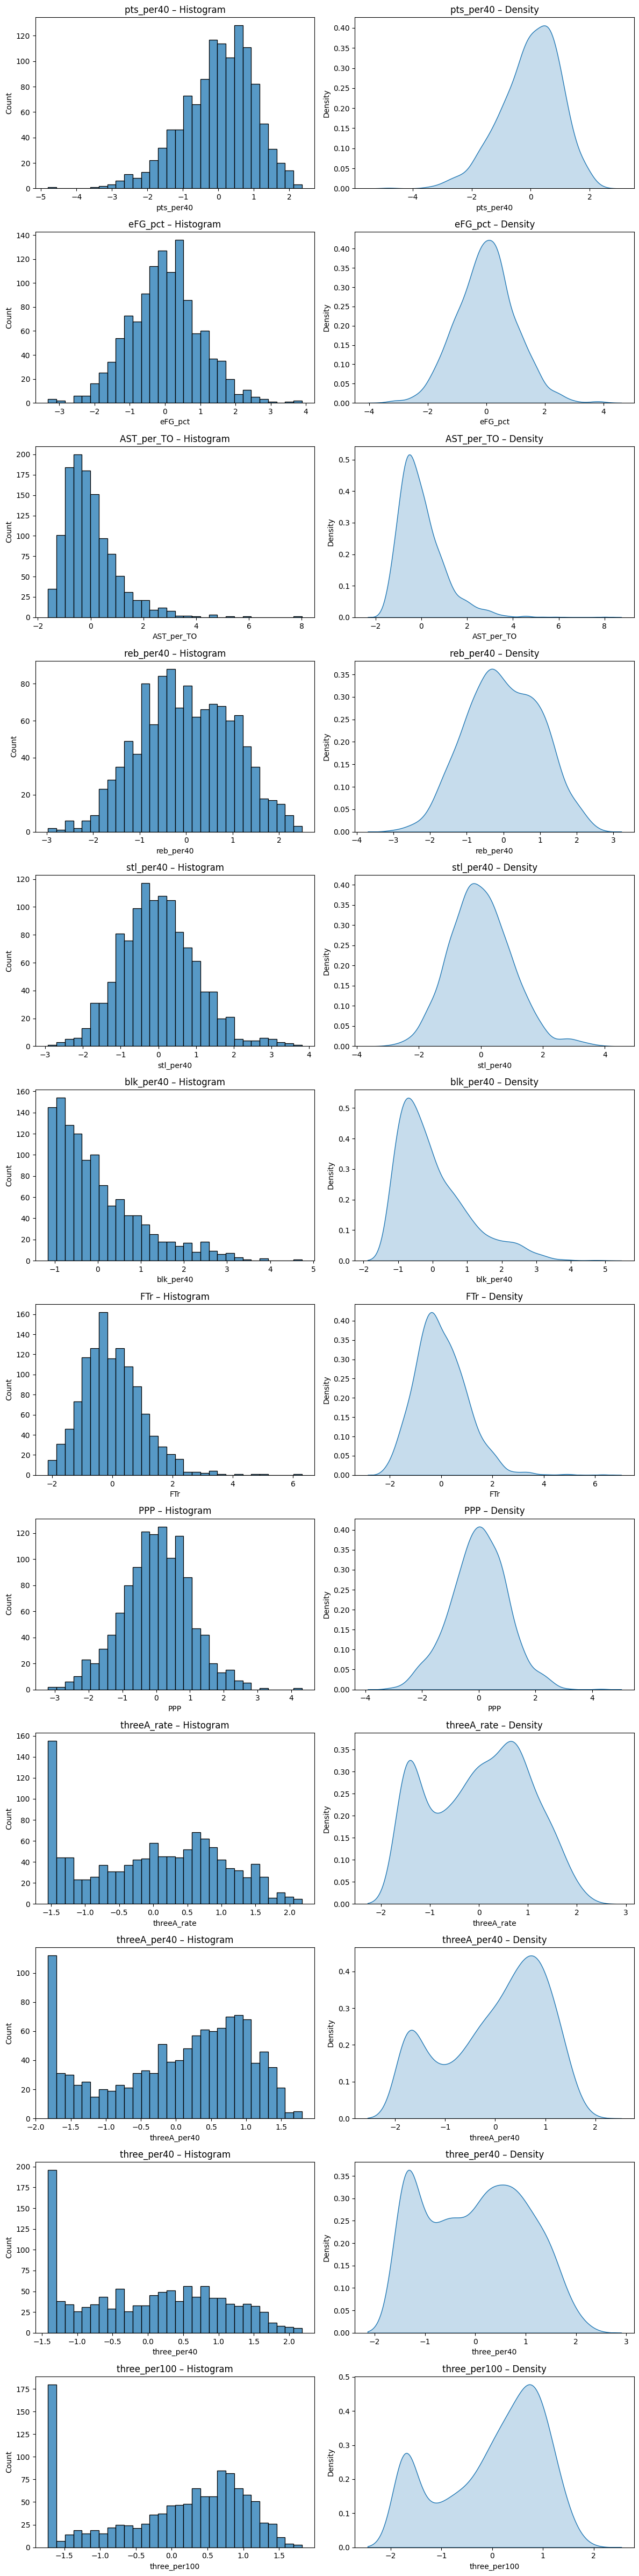

In [13]:
# Histograms & density plots for selected features
features = [
    'pts_per40','eFG_pct','AST_per_TO','reb_per40',
    'stl_per40','blk_per40','FTr','PPP', 'threeA_rate','threeA_per40','three_per40','three_per100'
]

fig, axes = plt.subplots(len(features), 2, figsize=(12, 4*len(features)))

for ax_row, col in zip(axes, features):
    sns.histplot(df_clean[col], bins=30, ax=ax_row[0], kde=False)
    ax_row[0].set_title(f"{col} – Histogram")
    
    sns.kdeplot(df_clean[col], fill=True, ax=ax_row[1])
    ax_row[1].set_title(f"{col} – Density")

plt.tight_layout()


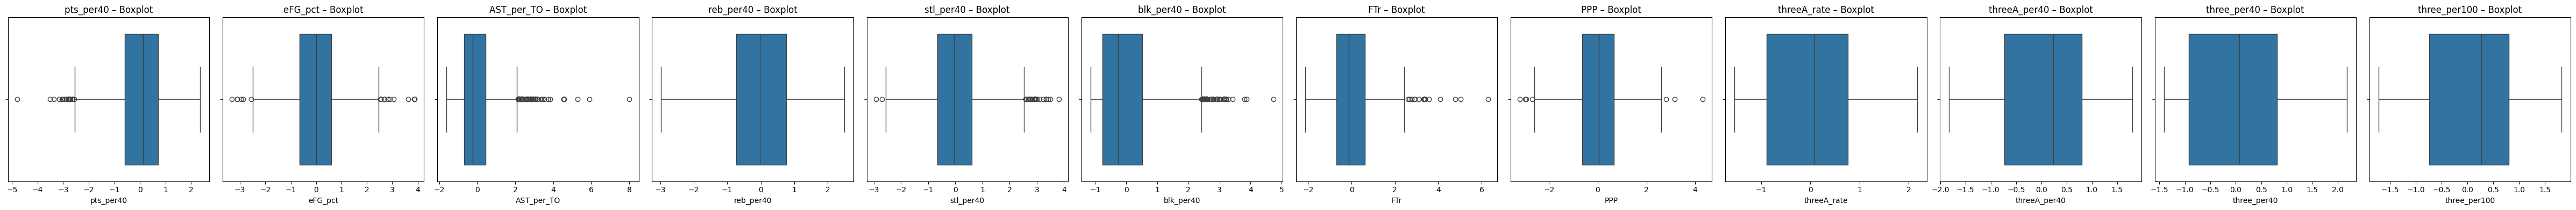

In [14]:
# Boxplots to spot outliers in the same features
fig, axes = plt.subplots(1, len(features), figsize=(4*len(features), 4), sharey=True)

for ax, col in zip(axes, features):
    sns.boxplot(x=df_clean[col], ax=ax)
    ax.set_title(f"{col} – Boxplot")

plt.tight_layout()


**Export Cleaned Dataset**


In [15]:
#export clean dataframe
df_clean.to_csv('df_clean.csv', index=False)
print("df_clean.csv saved, shape:", df_clean.shape)
print("df_clean head:")
print(df_clean.head())

df_clean.csv saved, shape: (1190, 81)
df_clean head:
     college   season  player_number_ind       player_ind    gp_ind    gs_ind  \
0  manhattan  2017-18                 35     Kayla Grimme  0.651041  1.140706   
1  manhattan  2017-18                 15      Amani Tatum  0.651041  1.230372   
2  manhattan  2017-18                  2      Gabby Cajou  0.651041 -1.459583   
3  manhattan  2017-18                 30     Mikki Guiton  0.432065 -0.562931   
4  manhattan  2017-18                 14  Taylor Williams  0.432065  0.513050   

   minutes_tot_ind  scoring_pts_ind  rebounds_tot_ind   ast_ind  ...  \
0         1.194649         2.084665          2.649148 -0.212553  ...   
1         1.565299         1.587597          0.357687  2.823309  ...   
2         1.046389         0.373448         -0.538972  2.011742  ...   
3        -0.753323        -0.490309         -0.572182 -1.054178  ...   
4         0.012687        -0.685877         -0.240086 -0.422960  ...   

   blk_share  to_share  tea

**Correlation Screening**

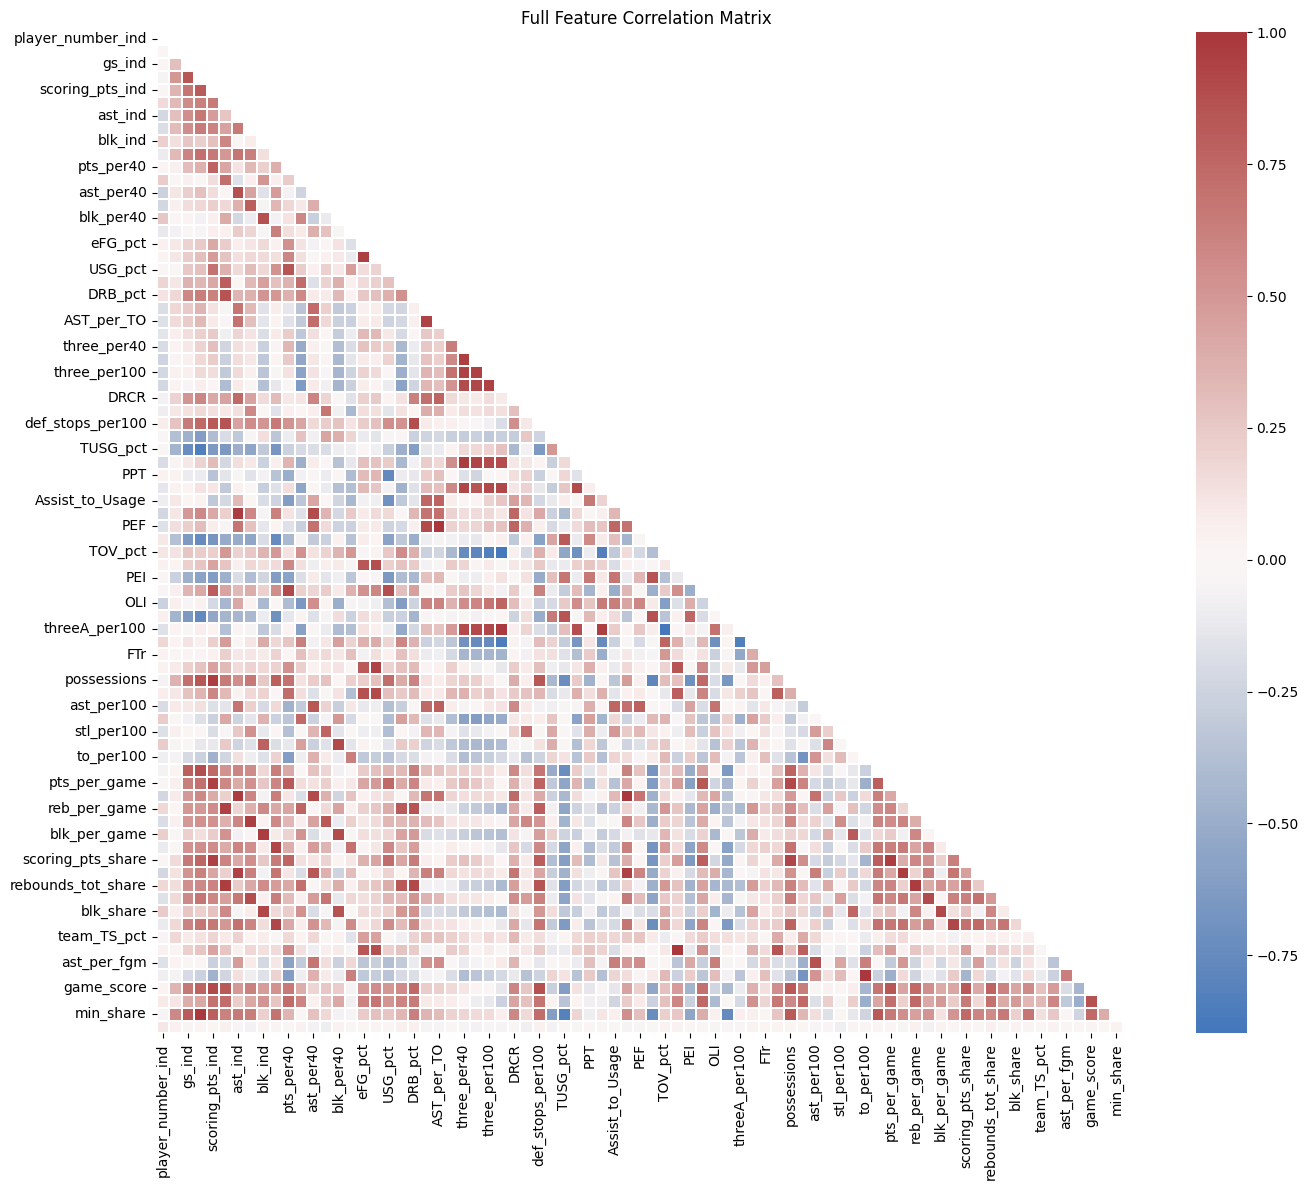

In [16]:
# Correlation Heatmap — full set before dropping
plt.figure(figsize=(14,12))
corr_full = df_clean.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr_full, dtype=bool))
sns.heatmap(
    corr_full,
    mask=mask,
    cmap='vlag',
    center=0,
    annot=False,
    linewidths=0.3
)
plt.title("Full Feature Correlation Matrix")
plt.tight_layout()


In [17]:
# Greedy Correlation Drop

# threshold
thresh = 0.90

# compute abs corr matrix on your scaled df_clean
numeric = df_clean.select_dtypes(include=[np.number])
corr    = numeric.corr().abs()

# list to hold columns to drop
to_drop = set()

# ordered list of columns
cols = corr.columns.tolist()

# greedy loop: for each (i,j) with j>i, if corr>thresh and j not yet marked, drop j
for i, col_i in enumerate(cols):
    if col_i in to_drop:
        continue
    for col_j in cols[i+1:]:
        if col_j in to_drop:
            continue
        if corr.loc[col_i, col_j] > thresh:
            to_drop.add(col_j)

print(f"Dropping {len(to_drop)} columns:\n", sorted(to_drop))

# now drop them
df_corr = df_clean.drop(columns=to_drop).copy()
print("Shape after greedy drop:", df_corr.shape)


Dropping 26 columns:
 ['APC', 'AST_per_TO', 'BoxCreation', 'Gravity', 'Spacing', 'TS_diff', 'TS_pct', 'ast_per_game', 'ast_share', 'blk_per100', 'blk_per_game', 'blk_share', 'game_score', 'min_share', 'possessions', 'pts_per_game', 'reb_per_game', 'rebounds_tot_share', 'scoring_pts_share', 'stl_per_game', 'threeA_per100', 'threeA_per40', 'three_per100', 'to_per_game', 'to_share', 'tov_rate']
Shape after greedy drop: (1190, 55)


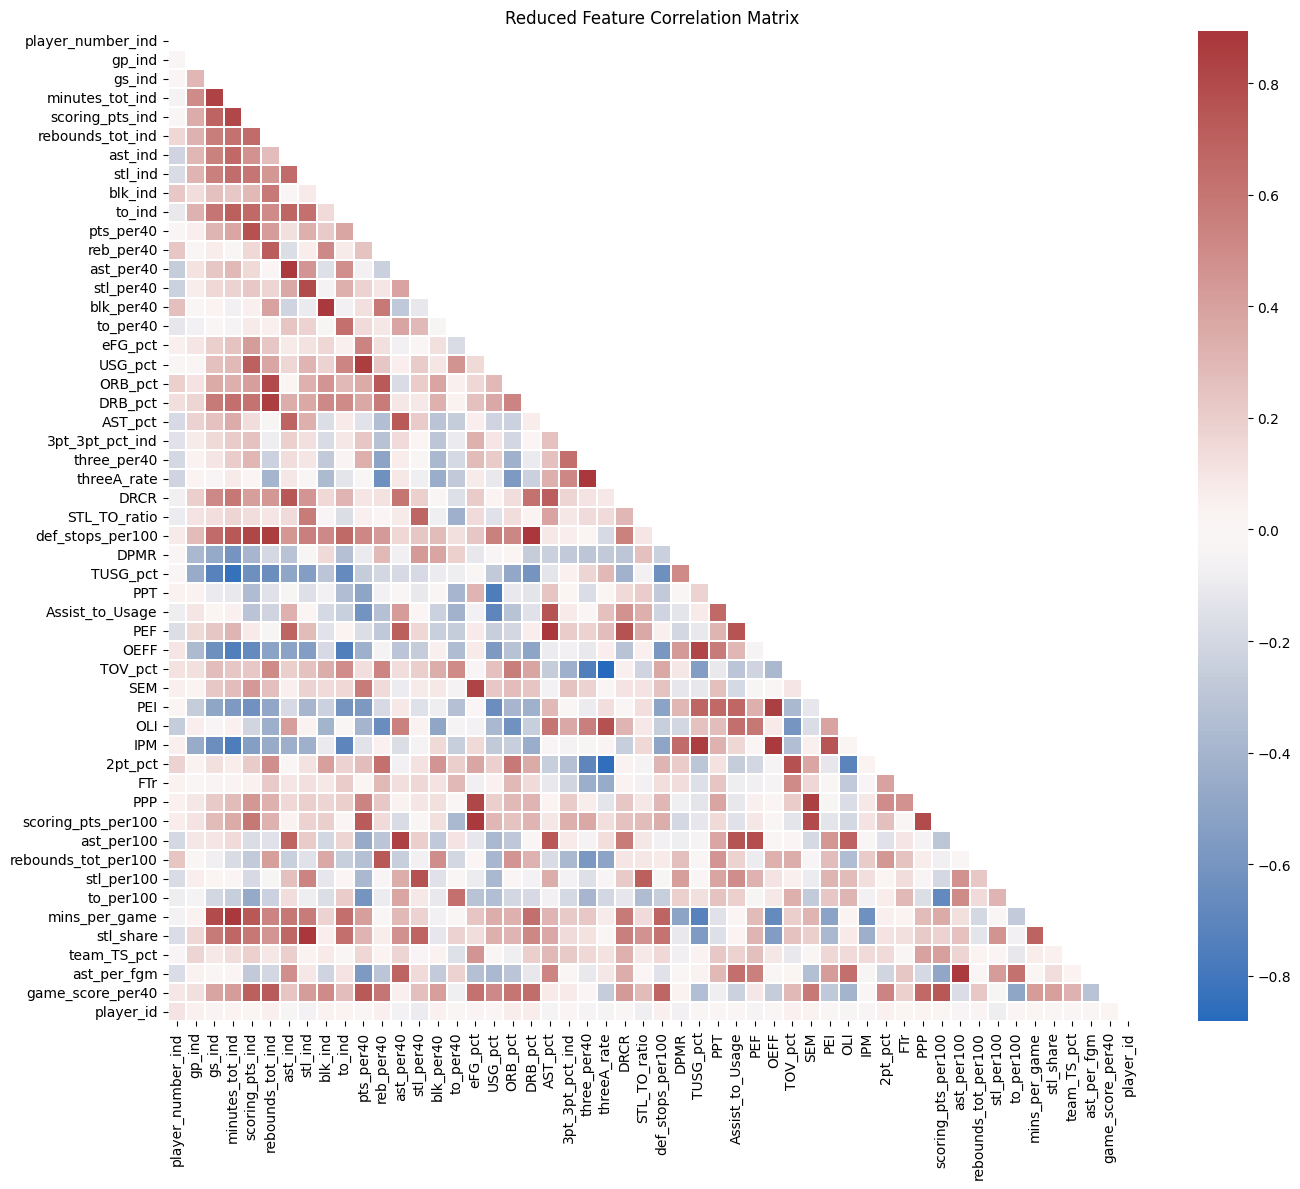

In [18]:
# Correlation Heatmap — after dropping high-corr
plt.figure(figsize=(14,12))
corr_reduced = df_corr.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr_reduced, dtype=bool))
sns.heatmap(
    corr_reduced,
    mask=mask,
    cmap='vlag',
    center=0,
    annot=False,
    linewidths=0.3
)
plt.title("Reduced Feature Correlation Matrix")
plt.tight_layout()


**Principal Component Analysis (PCA)**

In [19]:
# Fit a full PCA on the filtered & scaled features to inspect variance explained

# identify any identifier columns to exclude from PCA
id_cols = ['player_number_ind', 'player_ind', 'player_id']

# pick numeric feature columns (exclude identifiers)
feat_cols = [
    c for c in df_corr.select_dtypes(include=[np.number]).columns
    if c not in id_cols
]

# fit PCA with as many components as features
pca_full = PCA().fit(df_corr[feat_cols])

# cumulative explained variance
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# find how many PCs give you at least 90% of variance
n_pc = np.argmax(cumvar >= 0.90) + 1

target = float(P.get("pca_variance", 0.90))
maxc   = int(P.get("pca_max_components", 25))
n_pc   = max(1, min(int(n_pc), maxc, len(feat_cols)))

selected = load_json(PATHS["selection"], default={})

pca_param = P.get("pca_components", "auto")
if isinstance(pca_param, int):
    # fixed override
    selected["n_pca"] = int(pca_param)
else:
    # use the value your explore notebook selected
    selected["n_pca"] = int(n_pc)  

save_json(selected, PATHS["selection"])

print("Saved n_pca to:", PATHS["selection"], "->", selected["n_pca"])

print(f"Number of components for ≥90% variance: {n_pc}")

Saved n_pca to: /Users/savvasneofytou/Desktop/basketball/artifacts/run_20250827_204200/selection.json -> 10
Number of components for ≥90% variance: 10


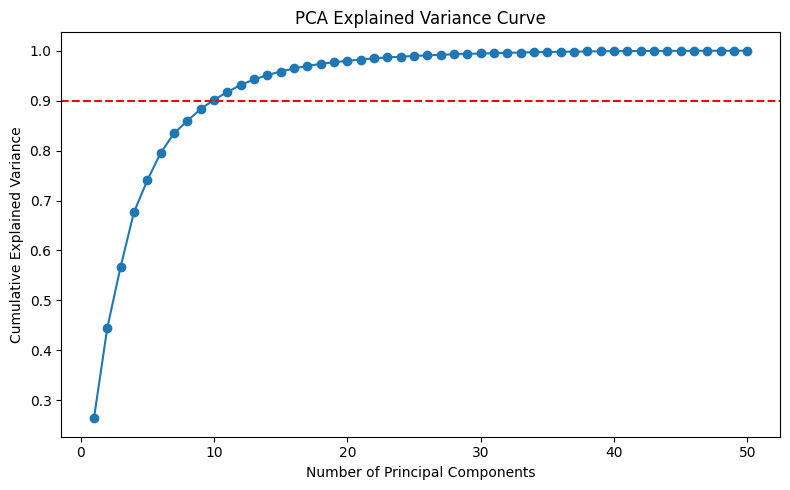

In [20]:
# Plot the cumulative explained‐variance curve (the “elbow” for PCA)

plt.figure(figsize=(8,5))
plt.plot(
    np.arange(1, len(cumvar)+1),
    cumvar,
    marker='o',
    linestyle='-'
)
plt.axhline(0.90, color='red', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.tight_layout()
plt.show()


In [21]:
# Transform your data into the top n_pc principal components

# re‐fit PCA with the chosen number of components
pca = PCA(n_components=n_pc)
pcs = pca.fit_transform(df_corr[feat_cols])

# build a DataFrame of those PCs
pc_cols = [f"PC{i+1}" for i in range(n_pc)]
df_pca = pd.DataFrame(pcs, columns=pc_cols, index=df_corr.index)

# bring along your identifier columns
df_pca[id_cols] = df_corr[id_cols].values

print("df_pca ready with shape:", df_pca.shape)
df_pca.head()


df_pca ready with shape: (1190, 13)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,player_number_ind,player_ind,player_id
0,6.549108,-3.977663,0.822316,0.355264,-2.007420,0.921085,-2.250430,1.284659,0.105373,0.929712,35,Kayla Grimme,476
1,5.354320,5.615783,0.411257,0.296786,3.144035,0.255203,0.432638,0.421279,-0.109713,0.176786,15,Amani Tatum,51
2,1.840898,4.584421,-1.477845,1.392779,2.823188,-0.387966,1.767194,-0.985375,1.124689,1.438844,2,Gabby Cajou,289
3,-1.771620,-4.009135,0.898631,-1.281320,-1.044446,-0.027299,1.069726,-2.229451,1.269753,-0.306832,30,Mikki Guiton,643
4,-2.530855,2.130584,1.354107,-0.628895,-2.081206,2.448090,0.490361,0.176575,0.023823,-1.034502,14,Taylor Williams,836


PCA Validation and Checks

In [22]:
# Tabulate explained‐variance ratios
evr = pca_full.explained_variance_ratio_
cumvar = np.cumsum(evr)

var_df = pd.DataFrame({
    'PC':           [f'PC{i+1}' for i in range(len(evr))],
    'ExplainedVar': evr,
    'CumulativeVar': cumvar
})

print("Explained‐variance ratios:")
display(var_df.style.format({
    'ExplainedVar': '{:.3f}',
    'CumulativeVar':'{:.3f}'
}))


Explained‐variance ratios:


,PC,ExplainedVar,CumulativeVar
0,PC1,0.264,0.264
1,PC2,0.181,0.445
2,PC3,0.122,0.567
3,PC4,0.109,0.676
4,PC5,0.064,0.740
5,PC6,0.055,0.795
6,PC7,0.039,0.834
7,PC8,0.025,0.860
8,PC9,0.023,0.883
9,PC10,0.019,0.902


In [23]:
# Confirm PCs are uncorrelated
pc_corr = df_pca[pc_cols].corr().round(3)
print("Correlation matrix of PCs (should be ≈identity):")
display(pc_corr)


Correlation matrix of PCs (should be ≈identity):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,1.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
PC2,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0
PC3,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
PC4,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,0.0
PC5,-0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0
PC6,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,0.0
PC7,0.0,0.0,0.0,0.0,-0.0,0.0,1.0,0.0,0.0,0.0
PC8,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0
PC9,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0
PC10,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,1.0


In [24]:
# Inspect feature loadings for the first two PCs
loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols,
    columns=pc_cols
)

for pc in pc_cols[:2]:
    print(f"Top 8 absolute loadings for {pc}:")
    display(
        loadings[pc]
         .abs()
         .sort_values(ascending=False)
         .head(8)
         .rename_axis("feature")
         .reset_index(name="abs_loading")
    )


Top 8 absolute loadings for PC1:


,feature,abs_loading
0,scoring_pts_ind,0.247232
1,def_stops_per100,0.242115
2,minutes_tot_ind,0.229694
3,rebounds_tot_ind,0.228564
4,TUSG_pct,0.219898
5,DRB_pct,0.216324
6,mins_per_game,0.213967
7,OEFF,0.208216


Top 8 absolute loadings for PC2:


,feature,abs_loading
0,OLI,0.283351
1,AST_pct,0.278559
2,PEF,0.265841
3,ast_per100,0.263075
4,ast_per40,0.245517
5,ast_ind,0.239432
6,Assist_to_Usage,0.232869
7,ast_per_fgm,0.218292


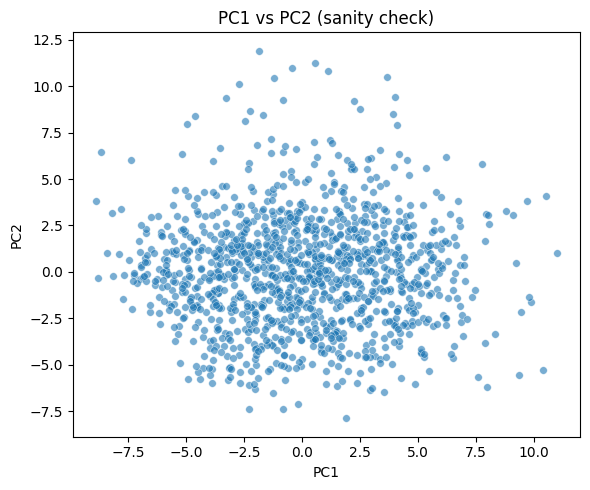

In [25]:
# Quick PC1 vs PC2 scatter
plt.figure(figsize=(6,5))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, s=30, alpha=0.6)
plt.title("PC1 vs PC2 (sanity check)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


**Export PCA Dataset to CSV**

In [26]:
#export pca dataframe
df_pca.to_csv('df_pca.csv', index=True)
print("df_pca.csv saved, shape:", df_pca.shape)
print("df_pca head:")
print(df_pca.head())

df_pca.csv saved, shape: (1190, 13)
df_pca head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  6.549108 -3.977663  0.822316  0.355264 -2.007420  0.921085 -2.250430   
1  5.354320  5.615783  0.411257  0.296786  3.144035  0.255203  0.432638   
2  1.840898  4.584421 -1.477845  1.392779  2.823188 -0.387966  1.767194   
3 -1.771620 -4.009135  0.898631 -1.281320 -1.044446 -0.027299  1.069726   
4 -2.530855  2.130584  1.354107 -0.628895 -2.081206  2.448090  0.490361   

        PC8       PC9      PC10 player_number_ind       player_ind player_id  
0  1.284659  0.105373  0.929712                35     Kayla Grimme       476  
1  0.421279 -0.109713  0.176786                15      Amani Tatum        51  
2 -0.985375  1.124689  1.438844                 2      Gabby Cajou       289  
3 -2.229451  1.269753 -0.306832                30     Mikki Guiton       643  
4  0.176575  0.023823 -1.034502                14  Taylor Williams       836  
